# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install scikit-learn==1.3.0 -q

     |████████████████████████████████| 10.9 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 60.5 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression


In [3]:
# константа для random_state
RANDOM_STATE = 42

## Подготовка данных

Загрузим датасет

In [4]:
path_1 = '/datasets/autos.csv'
path_2 = "C:\\DS\\YP\\S14\\autos.csv"


def generate_data (path_1, path_2):
    if os.path.exists(path_1):
        df = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        df = pd.read_csv(path_2)
    else:
        print('Something is wrong')
    return df

In [5]:
df = generate_data(path_1, path_2)
# провреим загрузку датасета
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Описание данных

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак:**
* Price — цена (евро)

Заменим название столбцов на название со строчной буквы и отделяя слова нижним подчеркиванием

In [6]:
# создаём список с изменёнными названиями столбцов
new_columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power'
               , 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired'
               , 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']

In [7]:
# производим замена
df.columns = new_columns
# проверка
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Выведем информацию о датафрейме

In [8]:
def get_df_info(df):
    display(df.sample(5))
    df.info()
    display(df.describe(include='all').T)

In [9]:
get_df_info(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
13328,2016-03-08 03:59:49,5399,sedan,2003,manual,131,a4,5000,10,petrol,audi,NaN,2016-03-08 00:00:00,0,13627,2016-04-06 06:45:44
318539,2016-03-29 18:51:13,350,wagon,2002,manual,166,156,150000,10,petrol,alfa_romeo,NaN,2016-03-29 00:00:00,0,29574,2016-03-31 12:17:24
316910,2016-03-27 14:41:25,2999,sedan,1999,auto,105,3er,150000,10,petrol,bmw,no,2016-03-27 00:00:00,0,25421,2016-04-05 08:17:14
343907,2016-03-31 01:57:05,0,wagon,1994,manual,280,100,150000,3,petrol,audi,no,2016-03-31 00:00:00,0,78554,2016-04-06 01:45:41
175099,2016-03-25 14:57:05,4890,wagon,2009,auto,105,caddy,150000,11,gasoline,volkswagen,no,2016-03-25 00:00:00,0,53783,2016-03-25 18:30:01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
vehicle_type,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
fuel_type,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим на дубликаты

In [10]:
def get_random_filled_series(df, column):
    weights = df[column].value_counts(normalize=True)
    nulls = df[df[column].isna()][column]
    random_values = random.choices(weights.index, weights=weights, k=len(nulls))
    return pd.Series(random_values, index=nulls.index)

get_random_filled_series(df, 'vehicle_type')
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [11]:
df.duplicated().sum()

4

Выведем дубликаты на экран

In [12]:
df[df.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


По факту строки дубликатами на являются. Оставим как есть

Проверим на пропуски

In [13]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Найдём количество уникальных значений в столбцах с пропусками

In [14]:
print('vehicle_type:',df.vehicle_type.unique(),'\n')
print('gearbox:', df.gearbox.unique(),'\n')
print('model:', df.model.unique(),'\n')
print('fuel_type:', df.fuel_type.unique(),'\n')
print('repaired:', df.repaired.unique())

vehicle_type: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

gearbox: ['manual' 'auto' nan] 

model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider'

Пропуски скорее всего образоывались в результате ошибок при сборе данных, либо пользователи на заполенили анкеты полностью. Т.е. пропуски имеют случайное значение.

Можем заменить пропущенные значения на заглушку: "unknown"

In [15]:
df[['vehicle_type', 'model', 'fuel_type', 'gearbox']] = df[['vehicle_type', 'model', 'fuel_type', 'gearbox']].fillna('unknown')
# проверка
df.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

В оставшемся столбц 'repaired' заменим пропуски на значение, которые уже есть в таблице, согласно их долям в таблице.

In [16]:
# yайдём колчичество и соотношение данных
print(df['repaired'].value_counts())
print()
print(df['repaired'].value_counts(normalize=True))

no     247161
yes     36054
Name: repaired, dtype: int64

no     0.872697
yes    0.127303
Name: repaired, dtype: float64


In [17]:
def get_random_filled_series(df, column):
    weights = df[column].value_counts(normalize=True)
    nulls = df[df[column].isna()][column]
    random_values = random.choices(weights.index, weights=weights, k=len(nulls))
    return pd.Series(random_values, index=nulls.index)

df['repaired'] = df['repaired'].fillna(get_random_filled_series(df, 'repaired'))

# Проверка
print(df['repaired'].value_counts())
print()
print(df['repaired'].value_counts(normalize=True))

no     309373
yes     44996
Name: repaired, dtype: int64

no     0.873025
yes    0.126975
Name: repaired, dtype: float64


Проверим, все ли пропуски заменены.

In [18]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Построим гистограммы данных и диаграммы размаха, чтобы проверить распределение

Напишем функции для постройки графков

In [19]:
# функция для отрисовки гистрограмм
def draw_histogram (df, column, title, bins=15,
                   figsize=(14,5), color='red',
                   xlabel='', ylabel='', rotation=0,
                   xlim=None, ylim=None):
    plt.figure(figsize=figsize)
    
    ax = sns.displot(
        df[column],
        color=color,
        kde=False,
        bins=bins
    )
    
    if (xlim != None):
        plt.xlim(xlim)
    if (ylim != None):
        plt.ylim(ylim)
        
    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        title=title
    )    
    
    if rotation != 0:
        plt.xticks(rotation=rotation)


In [20]:
def draw_boxplot (df, column, title,
                 figsize=(14,5), color='red',
                 xlabel='', xlim=None,):
    plt.figure(figsize=figsize)
    
    ax = sns.boxplot(
        x=df[column],
        color=color
    )
    
    if(xlim != None):
        xlim=xlim
        
    ax.set(xlabel=xlabel,
          title=title
          )
    
    

Проверим и построим графики цен на автомобили

<Figure size 1008x360 with 0 Axes>

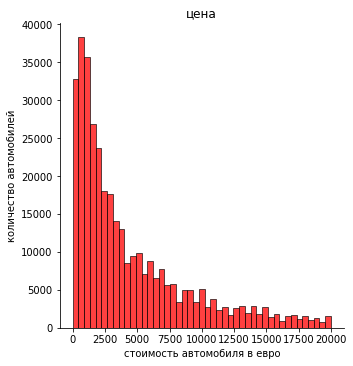

In [21]:
draw_histogram(df, column='price', title='цена',bins=45,
               xlabel='стоимость автомобиля в евро', ylabel='количество автомобилей')

Данные выглядят адекватно, большиство автомобилей стоимостью до 4000 евро

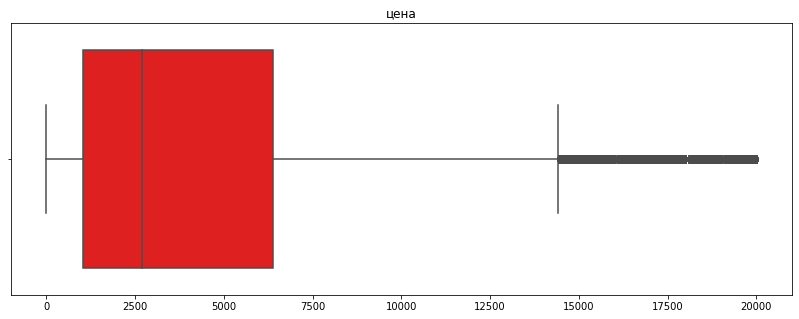

In [22]:
draw_boxplot(df, column='price', title='цена')

Автомобили стоимостью выше 15000 евро показаны как выборосы, удалять их не будем, так как данных довольно много и для обучения модели они нам тоже понадобятся.

Проверим и построим графики типа автомоболя

<Figure size 1008x360 with 0 Axes>

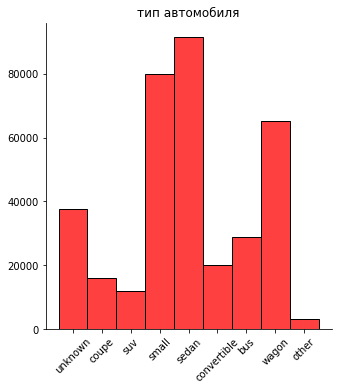

In [23]:
draw_histogram(df, column='vehicle_type', title='тип автомобиля', bins=30,
               rotation=45)

Неадекватных данных не обнаружено

Boxplot по типам автомобилей не показатален, его не строим

Далее потроим графики и проверим год регистрации автомобиля

<Figure size 1008x360 with 0 Axes>

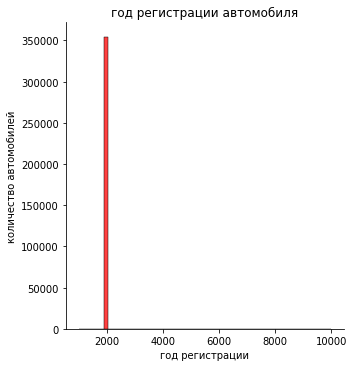

In [24]:
draw_histogram(df, column='registration_year', title='год регистрации автомобиля',bins=60,
               xlabel='год регистрации', ylabel='количество автомобилей')

Данные выглядят адекватными на графике не видно выбросов

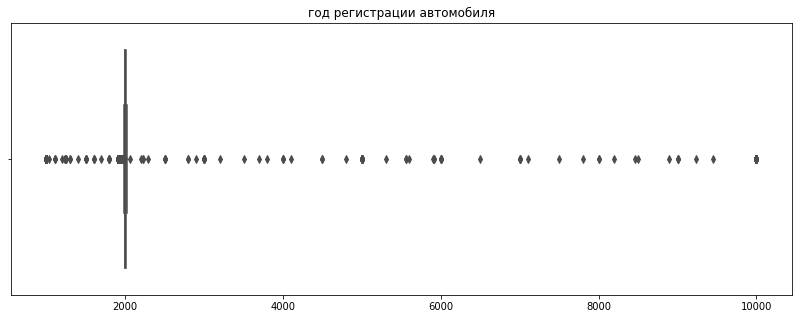

In [25]:
draw_boxplot(df, column='registration_year', title='год регистрации автомобиля')

Заметны выбросы, график показывает выбросы, примерно до конца 1980х

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df['registration_year'].value_counts().sort_index(ascending=False)

9999       26
9996        1
9450        1
9229        1
9000        3
8888        1
8500        1
8455        1
8200        1
8000        2
7800        1
7500        1
7100        1
7000        4
6500        1
6000        5
5911        2
5900        1
5600        1
5555        2
5300        1
5000       17
4800        1
4500        2
4100        1
4000        3
3800        1
3700        1
3500        1
3200        1
3000        7
2900        1
2800        2
2500        4
2290        1
2222        2
2200        1
2066        1
2019       25
2018     3959
2017    10441
2016     9599
2015     1302
2014     2537
2013     4131
2012     7178
2011     9909
2010    10764
2009    14503
2008    15391
2007    17183
2006    19900
2005    22109
2004    19611
2003    19763
2002    19092
2001    20124
2000    24490
1999    22728
1998    17899
1997    14666
1996    10835
1995     9607
1994     4841
1993     3438
1992     3002
1991     2762
1990     2806
1989     1318
1988      942
1987      667
1986  

Удалим данные до 1970 года.

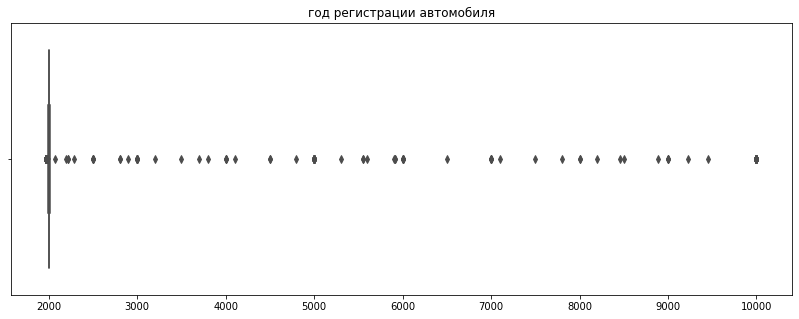

In [27]:
df = df.query('registration_year > 1970')
# проверка
draw_boxplot(df, column='registration_year', title='год регистрации автомобиля')

In [28]:
df['registration_year'].max()

9999

Оставим данные по автомобиля с регистрацией по 2016 год включительно

In [29]:
df = df.query('registration_year < 2017')

In [30]:
df[['date_crawled', 'registration_year']].head(100)

,date_crawled,registration_year
0,2016-03-24 11:52:17,1993
1,2016-03-24 10:58:45,2011
2,2016-03-14 12:52:21,2004
3,2016-03-17 16:54:04,2001
4,2016-03-31 17:25:20,2008
5,2016-04-04 17:36:23,1995
6,2016-04-01 20:48:51,2004
7,2016-03-21 18:54:38,1980
8,2016-04-04 23:42:13,2014
9,2016-03-17 10:53:50,1998


Далее проверим разделение по коробке передач

<Figure size 1008x360 with 0 Axes>

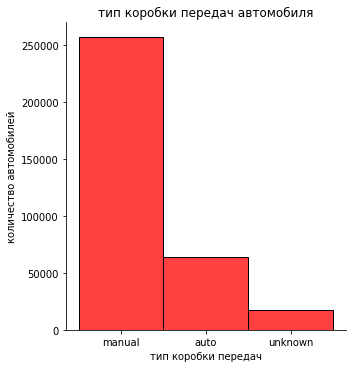

In [31]:
draw_histogram(df, column='gearbox', title='тип коробки передач автомобиля',bins=2,
               xlabel='тип коробки передач', ylabel='количество автомобилей')


Аномалий не обнаружено.
Boxplot по типк коробки передач не информативен

Далее проверим мощность двигателя

<Figure size 1008x1440 with 0 Axes>

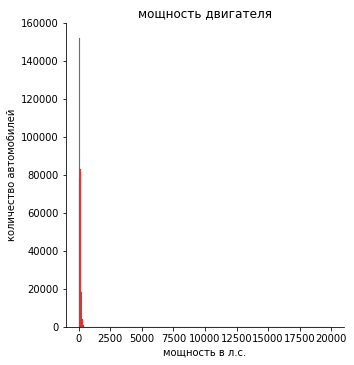

In [32]:
draw_histogram(df, column='power', title='мощность двигателя',bins=300, figsize=(14,20),
               xlabel='мощность в л.с.', ylabel='количество автомобилей')


Явно есть выборосы. Построим boxplot

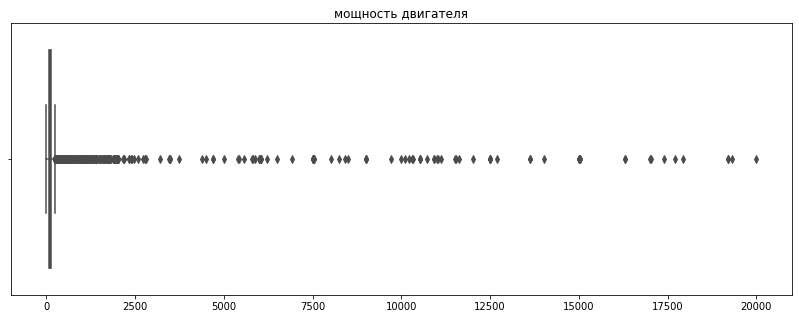

In [33]:
draw_boxplot(df, column='power', title='мощность двигателя')

In [34]:
df['power'].describe()

count    338168.000000
mean        111.217185
std         185.151538
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Большинство двигателей укладываются в диапазон от 75л.с. до 148 л.с.
Ограничим диапазон от 50л.с. до 250 л.с.

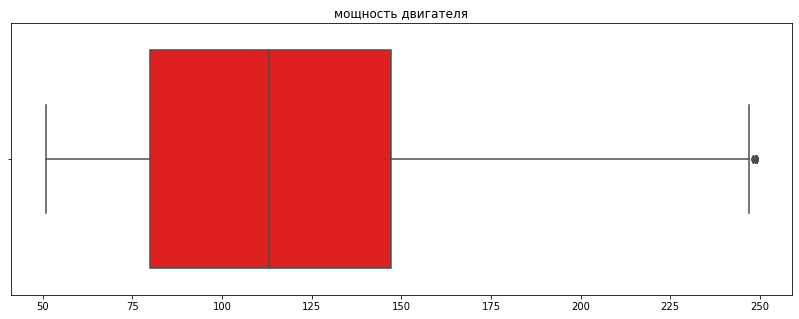

In [35]:
df=df.query('50.0 < power < 250.0')
# прверка
draw_boxplot(df, column='power', title='мощность двигателя')

Выбросы удалили.

Далее проверим пробег

<Figure size 1008x360 with 0 Axes>

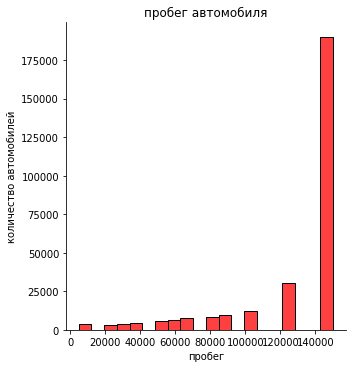

In [36]:
draw_histogram(df, column='kilometer', title='пробег автомобиля',bins=20,
               xlabel='пробег', ylabel='количество автомобилей'
              )

Данные выглядят адекватными.

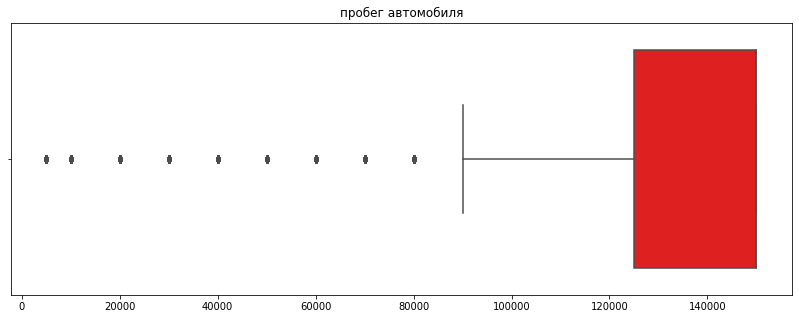

In [37]:
draw_boxplot(df, column='kilometer', title='пробег автомобиля')

Данные выглядят адекватными. Есть выбросы. Это автомобили с малым пробегом. Но и эти данные нам пригодятся.

Проверим данные по типу топлива.

<Figure size 1008x360 with 0 Axes>

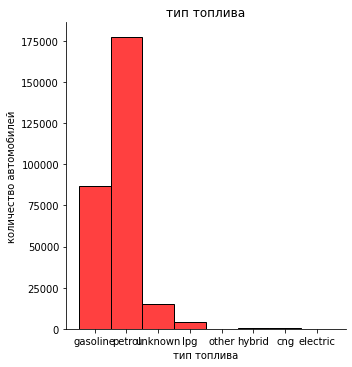

In [38]:
draw_histogram(df, column='fuel_type', title='тип топлива',bins=10,
               xlabel='тип топлива', ylabel='количество автомобилей'
              )

Данные выглядят адекватными

Проверим была ли машина в ремонте 

<Figure size 1008x360 with 0 Axes>

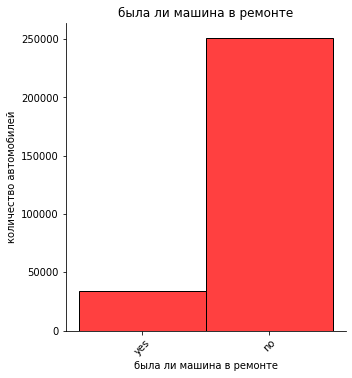

In [39]:
draw_histogram(df, column='repaired', title='была ли машина в ремонте',bins=30,
               xlabel='была ли машина в ремонте', ylabel='количество автомобилей',  rotation=45
              )

Данные выглядят адекватно

Предположим что столбцы:

* DateCrawled — дата скачивания анкеты из базы
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Не влияют на стоимость автомобиля. Удалим эти столбцы

In [40]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [41]:
# сначала сохраним датафрейм
df_full = df.copy()

# удалим лишние столбцы
df.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis= 1 , inplace= True)

# проверка
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [42]:
df.duplicated().sum()

24720

Считаем подготовку данных оконченной. Удалили пропуски. Пропуски в столбце 'repaired' заменили на данные согласно вероятности распределения. Проверили данные на адекватность и выбросы. Удалили выбросы. Также удалили лишние столбцы, которые не пригодятся в обучении модели.

In [43]:
df.registration_month.unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

In [44]:
df.registration_month.value_counts()

3     29123
6     26474
4     24718
5     24694
7     22679
10    21971
12    20330
11    20166
9     20114
1     19207
8     19011
0     18124
2     18102
Name: registration_month, dtype: int64

Cудя по количеству месяцев, месяцев 13, что вряд ли. Предположим, что 0 - это не указанный месяц. В таком случае заменим все значения 0 на рандомное в соотвествие распространённостью

In [45]:
# заменим значения 0 на non
df.loc[df['registration_month'] == 0, 'registration_month'] = np.nan

# заменим nan на рандомное число в соовествие с их долями в таблице
df['registration_month'] =  df['registration_month'].fillna(get_random_filled_series(df, 'registration_month'))

# проверка
df.registration_month.unique()

array([ 5.,  8.,  6.,  7., 10., 12., 11.,  2.,  3.,  1.,  4.,  9.])

Появилась точка. Вернём тип данных int

In [46]:
# проверям тип данных
print("тип данных до изменения", df.dtypes['registration_month'])

# меняем тип данных
df['registration_month'] = df['registration_month'].astype(np.int8)

# проверка изменений
print("тип данных после изменения",df.dtypes['registration_month'])
df.registration_month.unique()

тип данных до изменения float64
тип данных после изменения int8


array([ 5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int8)

## Обучение моделей

В этом разделе обучим и сравним  модели LightGBM, случайный лес и логистическая регрессия.

Сначало обучим модель градиентного бустинга LightGBM

Разделим модель на обучающую и тестовую выборки.

In [47]:
X = df.drop('price', axis=1)
y = df['price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=RANDOM_STATE
    )

X_train, X_valid, y_train, y_valid = train_test_split(
    X_test, y_test, test_size=0.25, random_state=RANDOM_STATE
    )

Выведем информацию о выборках

In [49]:
get_df_info(X_train)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
54566,sedan,1977,manual,90,other,150000,4,petrol,ford,no
305632,wagon,2005,manual,163,3er,150000,12,gasoline,bmw,no
57757,small,2009,manual,86,ibiza,125000,2,petrol,seat,no
74461,sedan,2004,auto,218,5er,150000,3,gasoline,bmw,no
293757,wagon,1989,manual,170,5er,150000,12,gasoline,bmw,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 106767 entries, 330633 to 200973
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicle_type        106767 non-null  object
 1   registration_year   106767 non-null  int64 
 2   gearbox             106767 non-null  object
 3   power               106767 non-null  int64 
 4   model               106767 non-null  object
 5   kilometer           106767 non-null  int64 
 6   registration_month  106767 non-null  int8  
 7   fuel_type           106767 non-null  object
 8   brand               106767 non-null  object
 9   repaired            106767 non-null  object
dtypes: int64(3), int8(1), object(6)
memory usage: 8.2+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vehicle_type,106767,9,sedan,30305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,106767.0,NaN,NaN,NaN,2003.048817,6.1011,1971.0,1999.0,2003.0,2007.0,2016.0
gearbox,106767,3,manual,84702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,106767.0,NaN,NaN,NaN,118.587897,44.171356,51.0,80.0,113.0,147.0,249.0
model,106767,246,golf,9485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,106767.0,NaN,NaN,NaN,128391.403711,36763.843014,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,106767.0,NaN,NaN,NaN,6.37564,3.345772,1.0,3.0,6.0,9.0,12.0
fuel_type,106767,8,petrol,66587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,106767,40,volkswagen,22875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
repaired,106767,2,no,94222,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
get_df_info(X_test)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
286945,wagon,2006,manual,140,a3,150000,2,gasoline,audi,no
258959,small,2002,manual,75,twingo,150000,6,unknown,renault,no
225305,sedan,2004,manual,140,golf,150000,11,gasoline,volkswagen,yes
269925,wagon,2011,auto,184,5er,150000,1,gasoline,bmw,no
236674,small,1998,manual,75,golf,150000,9,petrol,volkswagen,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 142357 entries, 249948 to 74101
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicle_type        142357 non-null  object
 1   registration_year   142357 non-null  int64 
 2   gearbox             142357 non-null  object
 3   power               142357 non-null  int64 
 4   model               142357 non-null  object
 5   kilometer           142357 non-null  int64 
 6   registration_month  142357 non-null  int8  
 7   fuel_type           142357 non-null  object
 8   brand               142357 non-null  object
 9   repaired            142357 non-null  object
dtypes: int64(3), int8(1), object(6)
memory usage: 11.0+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vehicle_type,142357,9,sedan,40450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,142357.0,NaN,NaN,NaN,2003.038832,6.098979,1971.0,1999.0,2003.0,2007.0,2016.0
gearbox,142357,3,manual,112940,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,142357.0,NaN,NaN,NaN,118.535724,44.123828,51.0,80.0,113.0,147.0,249.0
model,142357,248,golf,12593,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,142357.0,NaN,NaN,NaN,128505.693433,36666.251441,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,142357.0,NaN,NaN,NaN,6.375816,3.346651,1.0,3.0,6.0,9.0,12.0
fuel_type,142357,8,petrol,88743,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,142357,40,volkswagen,30578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
repaired,142357,2,no,125631,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
get_df_info(X_valid)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
44496,wagon,2006,manual,150,159,150000,5,gasoline,alfa_romeo,no
244072,wagon,1991,manual,129,3er,150000,8,petrol,bmw,no
31491,suv,2010,manual,163,i_reihe,100000,6,lpg,hyundai,no
118041,sedan,1997,manual,90,colt,150000,7,lpg,mitsubishi,no
129788,wagon,2001,manual,101,focus,30000,12,lpg,ford,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35590 entries, 312156 to 169156
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   vehicle_type        35590 non-null  object
 1   registration_year   35590 non-null  int64 
 2   gearbox             35590 non-null  object
 3   power               35590 non-null  int64 
 4   model               35590 non-null  object
 5   kilometer           35590 non-null  int64 
 6   registration_month  35590 non-null  int8  
 7   fuel_type           35590 non-null  object
 8   brand               35590 non-null  object
 9   repaired            35590 non-null  object
dtypes: int64(3), int8(1), object(6)
memory usage: 2.7+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vehicle_type,35590,9,sedan,10145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,35590.0,NaN,NaN,NaN,2003.008879,6.092599,1971.0,1999.0,2003.0,2007.0,2016.0
gearbox,35590,3,manual,28238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,35590.0,NaN,NaN,NaN,118.379208,43.981187,51.0,80.0,113.0,147.0,249.0
model,35590,242,golf,3108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,35590.0,NaN,NaN,NaN,128848.552964,36370.272952,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,35590.0,NaN,NaN,NaN,6.376342,3.349336,1.0,3.0,6.0,9.0,12.0
fuel_type,35590,8,petrol,22156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,35590,39,volkswagen,7703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
repaired,35590,2,no,31409,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создадим наборы данных для lightGBM

In [52]:
# переведём категориальные признаки подборки в тип "category"
X_category = X.select_dtypes(include='object').columns.to_list()
X[X_category] = X[X_category].astype('category')
X_train[X_category] = X_train[X_category].astype('category')
X_test[X_category] = X_test[X_category].astype('category')
X_valid[X_category] = X_valid[X_category].astype('category')

# загружем данные
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)



In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106767 entries, 330633 to 200973
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        106767 non-null  category
 1   registration_year   106767 non-null  int64   
 2   gearbox             106767 non-null  category
 3   power               106767 non-null  int64   
 4   model               106767 non-null  category
 5   kilometer           106767 non-null  int64   
 6   registration_month  106767 non-null  int8    
 7   fuel_type           106767 non-null  category
 8   brand               106767 non-null  category
 9   repaired            106767 non-null  category
dtypes: category(6), int64(3), int8(1)
memory usage: 4.1 MB


Укажем параметры для модели lightGBM

In [54]:
parameters_1 =  {
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'verbose': -1
}

Обучим модель lightGBM, сначала со станадартными параметерами. Будем замерять время выполнения ячеек.

In [55]:
%%time
# обучение модели lightGBM

model_1 = lgb.train(
    parameters_1, 
    train_set=train_data,
    valid_sets=valid_data,
    early_stopping_rounds=30
    )



/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 1.95822e+07
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 1.93329e+07
[3]	valid_0's l2: 1.90886e+07
[4]	valid_0's l2: 1.88489e+07
[5]	valid_0's l2: 1.8614e+07
[6]	valid_0's l2: 1.83835e+07
[7]	valid_0's l2: 1.81577e+07
[8]	valid_0's l2: 1.79365e+07
[9]	valid_0's l2: 1.77192e+07
[10]	valid_0's l2: 1.75068e+07
[11]	valid_0's l2: 1.72979e+07
[12]	valid_0's l2: 1.70938e+07
[13]	valid_0's l2: 1.68847e+07
[14]	valid_0's l2: 1.66803e+07
[15]	valid_0's l2: 1.64839e+07
[16]	valid_0's l2: 1.62865e+07
[17]	valid_0's l2: 1.60969e+07
[18]	valid_0's l2: 1.59068e+07
[19]	valid_0's l2: 1.57244e+07
[20]	valid_0's l2: 1.55407e+07
[21]	valid_0's l2: 1.5361e+07
[22]	valid_0's l2: 1.51891e+07
[23]	valid_0's l2: 1.50157e+07
[24]	valid_0's l2: 1.48488e+07
[25]	valid_0's l2: 1.4683e+07
[26]	valid_0's l2: 1.45158e+07
[27]	valid_0's l2: 1.43612e+07
[28]	valid_0's l2: 1.42043e+07
[29]	valid_0's l2: 1.4051e+07
[30]	valid_0's l2: 1.38982e+07
[31]	valid_0's l2: 1.3

In [56]:
%%time

#предсказание модели
model_1_prediction_train = model_1.predict(X_train)
model_1_prediction_valid = model_1.predict(X_valid)


# вывод метрики RMSE
print("RMSE train:", mean_squared_error(y_train, model_1_prediction_train)**0.5)
print()
print("RMSE valid:", mean_squared_error(y_valid, model_1_prediction_valid)**0.5)

RMSE train: 2767.026642952109

RMSE valid: 2737.3479670727606
CPU times: user 828 ms, sys: 0 ns, total: 828 ms
Wall time: 802 ms


Значение RMSE в 2700+,что нас не вполне устраивает, нам нужно значение RMSE меньше. Поменяем параметры, чтобы посмотреть как они повлияют на скорость обучения модели и результат. Время обучения две с половиной минуты

Изменим глубину деревьев

In [57]:
parameters_2 =  {
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 63,
    'verbose': -1
}

In [58]:
%%time
# обучение модели lightGBM

model_2 = lgb.train(
    parameters_2, 
    train_set=train_data,
    valid_sets=valid_data,
    early_stopping_rounds=30
    )


[1]	valid_0's l2: 1.95299e+07
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 1.9229e+07


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	valid_0's l2: 1.89341e+07
[4]	valid_0's l2: 1.86451e+07
[5]	valid_0's l2: 1.83625e+07
[6]	valid_0's l2: 1.80856e+07
[7]	valid_0's l2: 1.78143e+07
[8]	valid_0's l2: 1.75488e+07
[9]	valid_0's l2: 1.72868e+07
[10]	valid_0's l2: 1.70307e+07
[11]	valid_0's l2: 1.67794e+07
[12]	valid_0's l2: 1.65332e+07
[13]	valid_0's l2: 1.62919e+07
[14]	valid_0's l2: 1.60542e+07
[15]	valid_0's l2: 1.58208e+07
[16]	valid_0's l2: 1.55924e+07
[17]	valid_0's l2: 1.53689e+07
[18]	valid_0's l2: 1.51494e+07
[19]	valid_0's l2: 1.49336e+07
[20]	valid_0's l2: 1.47226e+07
[21]	valid_0's l2: 1.45156e+07
[22]	valid_0's l2: 1.43112e+07
[23]	valid_0's l2: 1.41122e+07
[24]	valid_0's l2: 1.39167e+07
[25]	valid_0's l2: 1.37241e+07
[26]	valid_0's l2: 1.35357e+07
[27]	valid_0's l2: 1.33509e+07
[28]	valid_0's l2: 1.31695e+07
[29]	valid_0's l2: 1.29903e+07
[30]	valid_0's l2: 1.28145e+07
[31]	valid_0's l2: 1.26422e+07
[32]	valid_0's l2: 1.2473e+07
[33]	valid_0's l2: 1.23075e+07
[34]	valid_0's l2: 1.2145e+07
[35]	valid_0's l2

In [59]:
%%time
#предсказание модели
model_2_prediction_train = model_2.predict(X_train)
model_2_prediction_valid = model_2.predict(X_valid)


# вывод метрики RMSE
print("RMSE train:", mean_squared_error(y_train, model_2_prediction_train)**0.5)
print()
print("RMSE valid:", mean_squared_error(y_valid, model_2_prediction_valid)**0.5)

RMSE train: 2448.8008088993474

RMSE valid: 2431.906747001741
CPU times: user 1.54 s, sys: 0 ns, total: 1.54 s
Wall time: 1.59 s


Уточность модели увеличилась приблизительно на 10%, скорость обучения осталась увеличилась больше чем в 5 раз.

Изменим скорость обучения, глубину деревьев оставим ту же: 63

In [60]:
parameters_3 =  {
    'learning_rate': 0.05,
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 63,
    'verbose': -1
}

In [61]:
%%time
# обучение модели lightGBM

model_3 = lgb.train(
    parameters_3, 
    train_set=train_data,
    valid_sets=valid_data,
    early_stopping_rounds=30
    )


[1]	valid_0's l2: 1.83351e+07
Training until validation scores don't improve for 30 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's l2: 1.69792e+07
[3]	valid_0's l2: 1.57545e+07
[4]	valid_0's l2: 1.46402e+07
[5]	valid_0's l2: 1.36338e+07
[6]	valid_0's l2: 1.2722e+07
[7]	valid_0's l2: 1.188e+07
[8]	valid_0's l2: 1.11217e+07
[9]	valid_0's l2: 1.04254e+07
[10]	valid_0's l2: 9.79009e+06
[11]	valid_0's l2: 9.20588e+06
[12]	valid_0's l2: 8.68515e+06
[13]	valid_0's l2: 8.20453e+06
[14]	valid_0's l2: 7.76166e+06
[15]	valid_0's l2: 7.35856e+06
[16]	valid_0's l2: 6.99706e+06
[17]	valid_0's l2: 6.66248e+06
[18]	valid_0's l2: 6.35834e+06
[19]	valid_0's l2: 6.07998e+06
[20]	valid_0's l2: 5.8283e+06
[21]	valid_0's l2: 5.58872e+06
[22]	valid_0's l2: 5.37408e+06
[23]	valid_0's l2: 5.17267e+06
[24]	valid_0's l2: 4.99184e+06
[25]	valid_0's l2: 4.82366e+06
[26]	valid_0's l2: 4.67397e+06
[27]	valid_0's l2: 4.53388e+06
[28]	valid_0's l2: 4.40685e+06
[29]	valid_0's l2: 4.28396e+06
[30]	valid_0's l2: 4.174e+06
[31]	valid_0's l2: 4.07115e+06
[32]	valid_0's l2: 3.98081e+06
[33]	valid_0's l2: 3.8941e+06
[34]	valid_0's l2: 3.81

In [62]:
#предсказание модели
model_3_prediction_train = model_3.predict(X_train)
model_3_prediction_valid = model_3.predict(X_valid)


# вывод метрики RMSE
print("RMSE train:", mean_squared_error(y_train, model_3_prediction_train)**0.5)
print()
print("RMSE valid:", mean_squared_error(y_valid, model_3_prediction_valid)**0.5)

RMSE train: 1567.1165265111547

RMSE valid: 1633.4519887324966


Скорость обучеия увеличилась, и больше 4 минут, при это точность значительно улучшилась и RSME меньше 1600.


**Кодирование значение и альтернативная модель**

В датафрейме есть нечисловые категориальные данные, с которыми модель работать не сможет. Переведём их в числовые методом One-Hot Encoding, т.к. этот метод работат с любмыми моделями, в том числе co случайным лесом.
В lightGBM уже есть функция One-Hot Encoding, для ускорения работы и удобства, т.к. мы обучаем ещё и другую модель (линейную регрессию) перекодируем данные отдельно.

In [63]:
#категориальные признаки для OHE
#X_train.columns = X.columns.astype(str)
ohe_features = X.select_dtypes(include='category').columns.to_list()
#численные признаки
num_features = X.select_dtypes(exclude='category').columns.to_list()

print(ohe_features)
print(num_features)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
['registration_year', 'power', 'kilometer', 'registration_month']


In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284713 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        284713 non-null  category
 1   registration_year   284713 non-null  int64   
 2   gearbox             284713 non-null  category
 3   power               284713 non-null  int64   
 4   model               284713 non-null  category
 5   kilometer           284713 non-null  int64   
 6   registration_month  284713 non-null  int8    
 7   fuel_type           284713 non-null  category
 8   brand               284713 non-null  category
 9   repaired            284713 non-null  category
dtypes: category(6), int64(3), int8(1)
memory usage: 10.9 MB


In [65]:
# копируем данные
X_ohe = X.copy()

# таким образом обходим dummy-ловушку
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_ohe[ohe_features])

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках полной выборки, трансформируем её же
X_ohe[num_features] = scaler.fit_transform(X_ohe[num_features])

In [66]:
X_ohe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,coupe,1.302649,manual,1.627202,unknown,-0.095283,-0.412474,gasoline,audi,yes
2,suv,0.157973,auto,1.013541,grand,-0.095283,0.484210,gasoline,jeep,no
3,small,-0.332602,manual,-0.986539,golf,0.586264,-0.113579,petrol,volkswagen,no
4,small,0.812074,manual,-1.122908,fabia,-1.049449,0.185316,gasoline,skoda,no
5,sedan,-1.313752,manual,-0.372878,3er,0.586264,1.082000,petrol,bmw,yes


In [67]:
# кодируем тренировочную выборку энкодером обученным на полной выборке

X_train_ohe = X_train.copy()
# добавляем закодированные признаки в X_train_ohbe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ohe[ohe_features])


# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ohe = X_train_ohe.drop(ohe_features, axis=1)

# используем скелер обученный на полной выборке
X_train_ohe[num_features] = scaler.transform(X_train_ohe[num_features])

# смотрим на результат
X_train_ohe.head()

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
330633,-0.496127,-0.077411,0.586264,

In [68]:
# кодируем тестовую выборку энкодером обученным на полной выборке

X_test_ohe = X_test.copy()
X_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_ohe[ohe_features])

X_test_ohe = X_test_ohe.drop(ohe_features, axis=1)

# используем скелер обученный на полной выборке
X_test_ohe[num_features] = scaler.transform(
    X_test_ohe[num_features]
)

# смотрим на результат
X_test_ohe.head()

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
249948,0.485024,0.490793,0.586264,1.

In [69]:
# кодируем валидную выборку энкодером обученным на полной выборке

X_valid_ohe = X_valid.copy()
X_valid_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_valid_ohe[ohe_features])

X_valid_ohe = X_valid_ohe.drop(ohe_features, axis=1)

# используем скелер обученный на полной выборке
X_valid_ohe[num_features] = scaler.transform(
    X_valid_ohe[num_features]
)

# смотрим на результат
X_valid_ohe.head()

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
312156,-0.659652,1.695387,0.586264,-

Обучим модель **Линейную регрессию**

In [70]:
%%time

model_linear = LinearRegression()
model_linear.fit(X_train_ohe, y_train)


CPU times: user 6.96 s, sys: 2.9 s, total: 9.86 s
Wall time: 9.86 s


LinearRegression()

In [71]:
%%time
predictions_train = model_linear.predict(X_train_ohe)
predictions_valid = model_linear.predict(X_valid_ohe)

print("RMSE train:", mean_squared_error(y_train, predictions_train)**0.5)
print()
print("RMSE valid:", mean_squared_error(y_valid, predictions_valid)**0.5)

RMSE train: 2480.4637317289607

RMSE valid: 2467.196372088126
CPU times: user 235 ms, sys: 164 ms, total: 399 ms
Wall time: 393 ms


Значение RMSE по тренировочной и валидной выборках около 2500. Что сильно выше лучшего результата модели LightGBM

Проверим модель на тестовой выборке.

In [74]:
predictions_test = model_linear.predict(X_test_ohe)

print("RMSE test:", mean_squared_error(y_test, predictions_test)**0.5)

RMSE test: 2477.1534837581185


Значение RMSE на тестовой выборке совпадаем со значением на тренировочной и валидной и также сильно меньше лучшего результата LightGBM

## Анализ моделей

В итоге лучшей моделью признаём модель  model_1 c с параметрами:

    'learning_rate': 0.05,
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 63,
    'verbose': -1
    
Точность этой модели заметно выше чем в других варианах LightGBM, разница. При этом модель обучается в четыре раза медленне, чем первый вариант и немного быстрее чем второй.

У модели линейной регресси показатель RMSE равен на тренировочной выборке около 2500, но обученная модель не смогла адеватно предсказать значения по валидной выборке.

**Проведём испытвания лучшей, третьей модели на тестовой выборке**

In [73]:
%%time

#предсказание модели
model_prediction_test = model_3.predict(X_test)


# вывод метрики RMSE
print("RMSE test:", mean_squared_error(y_test, model_prediction_test)**0.5)

RMSE test: 1583.9612129631291
CPU times: user 2.11 s, sys: 0 ns, total: 2.11 s
Wall time: 2.1 s


Значение RMSE вполне хорошее, почти не отличается от значения RMSE на тренировочной и валидной выборок. Скорость предсказания достаточно высокая.

### Итоговый вывод

Подготовили данные. Удалили пропуски и дубликаты. Пропуски в столбце 'repaired' заменили на данные согласно вероятности распределения. Проверили данные на адекватность и выбросы. Удалили выбросы. Также удалили лишние столбцы, которые не пригодятся в обучении модели. 

Обучили модель c градиентным бустингом LightGBM, применив к ней три варианта параметров, меняя глубину деревьев и скорость обучения. Выбрали третий вариант как самый оптимальный по соотношению точности и скорости обучения.
